# 7 Linear Regression Models

4/27/22

This notebook uses the final processed data set, consisting of the California Enviroscans 1 through 4, and the warehouse business census counts for each zip code.

- [Initial setup](#Initial-setup)
- [Import and examine merged CAES and business count data.](#Import-and-examine-merged-CAES-and-business-count-data.)
- [Linear regressions on all numeric columns.](#Linear-regressions-on-all-numeric-columns.)
- [Linear regressions on time and space features.](#Linear-regressions-on-time-and-space-features.)
- [Linear regression on registered warehouse business counts alone](#Linear-regression-on-registered-warehouse-business-counts-alone)
- [Linear regressions on "social" features.](#Linear-regressions-on-"social"-features.)
- [Linear regressions on CAES scores.](#Linear-regressions-on-CAES-scores.)
- [Linear regressions on select impact columns](#Linear-regressions-on-select-impact-columns)


## Initial setup

### Import libraries

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

### Define functions for linear regression

In [85]:
#train test splits a dataframe, and makes a linear regression with cross validation
def linear_reg_split_cv(df, xcols, ycols, train_size = 0.25, cv=5, random_state = 1):
    x = df[xcols]
    y = df[ycols]
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        train_size = train_size,
                                                        random_state = random_state
                                                       )                                                        
    results = [['parameters', train_size, cv, random_state]]
    for ycol in ycols:
        lr = LinearRegression()
        lr.fit(x_train, y_train[ycol])
        cv_scores = cross_val_score(lr, x_train, y_train, cv=cv)
        test_score = lr.score(x_test, y_test[ycol])
        results.append([ycol, cv_scores, cv_scores.mean(), test_score])
    return results

In [88]:
##test the linear regression
#linear_reg_split_cv(amgd, list(set(numeric_cols)-set(health_cols)), health_cols)

In [86]:
# performs linear regressions with the above function over a range of train/test split sizes and crossval kfolds.
# not using gridsearchcv specifically to play with different
# gives cv scores on train set, average cv score, and score on test set.
def my_lr_grid_search(df, xcols, ycols, train_sizes=[0.25], cvs=[5], random_states = [1]):
    results = []
    for random_state in random_states:
        for cv in cvs:
            for train_size in train_sizes:
                these_results = linear_reg_split_cv(df, xcols, ycols, train_size = train_size, cv = cv, random_state = random_state)
                results.append(these_results)
    return results

In [89]:
#%%time
##test the linear searches over ranges of ttsplits and cvs

#numeric_cols_minus_health = list(set(numeric_cols)-set(health_cols))

#my_lr_grid_search(amgd, numeric_cols_minus_health, health_cols, train_sizes=np.array(range(5,7))/10., cvs=range(4,6))

In [160]:
# takes in the results of the my_lr_grid_search list and gives
# best cv score average and parameters yielding it,
# best test score and parameters, and 
# smallest difference between the two and parameters
def interpret_my_lr_grid_search(results, ycols):
    resultsarray = np.array(results, dtype = object)
    best_results = []
    for ycol_index in range(len(ycols)):
        this_best_results = [ycols[ycol_index]]
        #get run with best cv average
        cv_avg_scores = resultsarray[:, ycol_index + 1, 2]  #ycolindex +1 to get past the parameters line
        best_cv_avg = max(cv_avg_scores)
        best_cv_avg_index = list(cv_avg_scores).index(max(cv_avg_scores))
        this_best_results.append([f'{best_cv_avg:.5f}', resultsarray[best_cv_avg_index, 0 ]])
        #get run with best test score
        test_scores = resultsarray[:, ycol_index + 1, 3]
        best_test_score = max(test_scores)
        best_test_score_index = list(test_scores).index(max(test_scores))
        this_best_results.append([f'{best_test_score:.5f}',resultsarray[best_test_score_index, 0]])
        #get run with best difference between the scores (balanced fitting)
        differences = cv_avg_scores - test_scores
        best_difference = min(differences)
        best_difference_index = list(differences).index(min(differences))
        this_best_results.append([f'{best_difference:.5f}', resultsarray[best_difference_index, 0]])
        #add results to final list
        best_results.append(this_best_results)
    return best_results

In [330]:
# takes a dataframe, xcols, and coefficients for ycols from a linear model,
# and returns a list of coefficients scaled relative to breadth of xcols
# distributions

def get_scaled_coefs(df, xcols, coefs):
    df_std = df[xcols].std().to_numpy()
    #piecewise multiply coefs with stds. since coefs are in units ycol/xcol, multiply by std to yield ycol/(reduced xcol)
    reduced_coefs = np.multiply(df_std, coefs)
    return reduced_coefs

In [285]:
# make a single fit with a given fold. The folding concept is mixing train-test-split with cv k-folds, since
# this doesn't use a test set. The intention is to give it a number of folds matching the combination
# of tts and cv in the gridsearch.

# takes a dataframe, xcols for features, ycol a single target, number of kfolds cv, and a random state if you want for
# for the cross_val_score.
def single_fit_cv(df, xcols, ycol, cv):
    x = df[xcols]
    y = df[ycol]
    lr = LinearRegression()
    gs = GridSearchCV(lr, param_grid={}, cv=cv)
    gs.fit(x, y)
    print(f'best score:{gs.best_score_}')
    print('coefs:')
    print(gs.best_estimator_.coef_)
    return gs.best_estimator_.coef_
    
    

In [292]:
#does the above, but simply fits to a linear regression.
def single_fit(df, xcols, ycol):
    x = df[xcols]
    y = df[ycol]
    lr = LinearRegression()
    lr.fit(x, y)
    print(f'score:{lr.score(x,y)}')
    print('coefs:')
    print(lr.coef_)
    return lr.coef_

In [281]:
warehouse_cols

['est gen', 'est cold', 'est farm', 'est other']

In [308]:
#gets some values and makes a bar chart with the appropriate labels.
def barh_coefs(coefs, ycols, xlim= 2, title = 'Feature coefficients'):
    plt.figure(figsize = (8,8))
    plt.barh(ycols, width = coefs)
    plt.xlim(-xlim, xlim)
    plt.title(title)
    plt.show()

## Import and examine merged CAES and business count data.

In [19]:
#import the merged CAESes 1-4 and business-counts-by-zip data 
all_merged_filepath = '../processed_data/all_merged.csv'
#amgd -- all merged dataframe
amgd = pd.read_csv(all_merged_filepath)
amgd.head()

,zip,total population,ozone,ozone pctl,pm2.5,pm2.5 pctl,diesel pm,diesel pm pctl,pesticides,pesticides pctl,...,cardiovascular disease,cardiovascular disease pctl,housing burden,housing burden pctl,census_year,est total,est gen,est cold,est farm,est other
0,93706,41087,0.177311,76.55,15.61,95.96,6.14,56.19,1120.30,90.59,...,NaN,NaN,NaN,NaN,2012,4,4,0,0,0
1,93307,82658,0.512336,93.70,19.40,99.69,9.57,64.73,7128.70,98.37,...,NaN,NaN,NaN,NaN,2012,1,0,0,1,0
2,95205,38069,0.022790,38.53,12.51,71.65,18.95,80.50,94.20,72.24,...,NaN,NaN,NaN,NaN,2012,1,0,0,0,1
3,93702,48607,0.317831,86.99,16.08,97.06,36.85,94.91,7.92,53.79,...,NaN,NaN,NaN,NaN,2012,0,0,0,0,0
4,90058,3223,0.015613,31.32,15.26,94.98,56.80,98.36,0.00,0.00,...,NaN,NaN,NaN,NaN,2012,35,12,19,0,4


In [20]:
#look at the data included with the imported file.
amgd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25444 entries, 0 to 25443
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zip                          25444 non-null  int64  
 1   total population             25444 non-null  int64  
 2   ozone                        25333 non-null  float64
 3   ozone pctl                   25333 non-null  float64
 4   pm2.5                        25286 non-null  float64
 5   pm2.5 pctl                   25286 non-null  float64
 6   diesel pm                    25444 non-null  float64
 7   diesel pm pctl               25444 non-null  float64
 8   pesticides                   25444 non-null  float64
 9   pesticides pctl              25444 non-null  float64
 10  traffic                      25353 non-null  float64
 11  traffic pctl                 25353 non-null  float64
 12  cleanup sites                25444 non-null  float64
 13  cleanup sites pc

In [21]:
# look at basic statistics of the numerical types.
# ces-per-range, county, and city are non-numerical and excluded here
# the 'zip' statistics have little meaning --- they are just region labels.
amgd.describe()

,zip,total population,ozone,ozone pctl,pm2.5,pm2.5 pctl,diesel pm,diesel pm pctl,pesticides,pesticides pctl,...,cardiovascular disease,cardiovascular disease pctl,housing burden,housing burden pctl,census_year,est total,est gen,est cold,est farm,est other
count,25444.000000,25444.000000,25333.000000,25333.000000,25286.000000,25286.000000,25444.000000,25444.000000,25444.000000,25444.000000,...,16059.000000,16059.000000,15768.000000,15768.000000,25444.000000,25444.000000,25444.000000,25444.000000,25444.000000,25444.000000
mean,92864.446156,5917.335796,0.068468,47.320326,10.221574,51.367337,12.497526,50.444645,296.028216,18.939449,...,10.837837,50.011075,18.908923,50.184404,2013.578958,1.959047,1.468716,0.181222,0.028730,0.280380
std,3380.897400,7251.318591,0.112443,30.957227,2.503114,29.032522,16.249286,28.787606,2555.276827,30.078159,...,4.953450,28.891888,8.509076,28.835873,0.590788,5.277823,4.470229,0.757449,0.182993,0.718911
min,32.000000,0.000000,0.000000,0.000000,1.651081,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.800000,0.012674,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91606.000000,3423.750000,0.030640,20.650000,8.559432,27.690338,0.000898,25.672060,0.000000,0.000000,...,7.265000,25.000000,12.600000,25.323194,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,92703.000000,4556.000000,0.045884,48.450529,10.370000,52.610000,7.650000,50.667918,0.000000,0.000000,...,9.760000,50.024925,17.600000,50.266160,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94564.000000,5946.000000,0.059387,73.930000,12.050000,77.977844,19.760000,75.400000,0.488285,34.110000,...,13.320000,75.070000,23.900000,75.107731,2014.000000,2.000000,1.000000,0.000000,0.000000,0.000000
max,96161.000000,105549.000000,1.285954,100.000000,21.200000,100.000000,253.731000,100.000000,91316.190000,100.000000,...,40.850000,100.000000,78.200000,100.000000,2014.000000,96.000000,86.000000,19.000000,3.000000,9.000000


### Remove percentile columns.

In [22]:
percentile_cols = [
 'ozone pctl',
 'pm2.5 pctl',
 'diesel pm pctl',
 'pesticides pctl',
 'traffic pctl',
 'cleanup sites pctl',
 'groundwater threats pctl',
 'haz. waste pctl',
 'imp. water bodies pctl',
 'solid waste pctl',
 'asthma pctl',
 'low birth weight pctl',
 'education pctl',
 'linguistic isolation pctl',
 'poverty pctl',
 'drinking water pctl',
 'tox. release pctl',
 'pollution burden pctl',
 'unemployment pctl',
 'pop. char. pctl',
 'cardiovascular disease pctl',
 'housing burden pctl'
]

In [23]:
#drop percentile columns.
amgd_pctls = amgd[percentile_cols]
amgd.drop(columns=percentile_cols, inplace = True)

In [24]:
#examine remaining columns
amgd.columns.to_list()

['zip',
 'total population',
 'ozone',
 'pm2.5',
 'diesel pm',
 'pesticides',
 'traffic',
 'cleanup sites',
 'groundwater threats',
 'haz. waste',
 'imp. water bodies',
 'solid waste',
 'pollution burden',
 'pollution burden score',
 'asthma',
 'low birth weight',
 'education',
 'linguistic isolation',
 'poverty',
 'pop. char. ',
 'pop. char. score',
 'ces_score',
 'ces_per_range',
 'year',
 'census tract',
 'county',
 'drinking water',
 'tox. release',
 'unemployment',
 'city',
 'latitude',
 'longitude',
 'ces_per',
 'cardiovascular disease',
 'housing burden',
 'census_year',
 'est total',
 'est gen',
 'est cold',
 'est farm',
 'est other']

### Extract numeric columns for linear regression.

In [41]:
#keep track of numeric and object columns.
numeric_cols = [
        column
        for column in amgd.columns.to_list()
        if amgd[column].dtype != 'object'
]

object_cols = [
        column
        for column in amgd.columns.to_list()
        if amgd[column].dtype =='object'
]

#save objects before removing them from the dataframe.
amgd_objects = amgd[object_cols]
amgd.drop(columns = object_cols, inplace=True)

### Inpute missing values.

In [36]:
amgd = amgd.fillna(amgd.median())

### Assign a label for target columns

These columns are the primary targets later in this notebook.

In [37]:
health_cols = ['asthma', #a
               'low birth weight', #b
              'cardiovascular disease' #c
              ]

In [216]:
amgd.std()

zip                       3.380897e+03
total population          7.251319e+03
ozone                     1.122076e-01
pm2.5                     2.495357e+00
diesel pm                 1.624929e+01
pesticides                2.555277e+03
traffic                   1.047231e+03
cleanup sites             2.058518e+01
groundwater threats       7.705163e+01
haz. waste                1.814200e+00
imp. water bodies         4.685733e+00
solid waste               4.378235e+00
pollution burden          1.298748e+01
pollution burden score    1.573062e+00
asthma                    2.884999e+01
low birth weight          1.330095e+00
education                 1.562460e+01
linguistic isolation      9.968631e+00
poverty                   1.948562e+01
pop. char.                1.966671e+01
pop. char. score          2.038822e+00
ces_score                 1.562855e+01
year                      2.979199e+00
census tract              2.583106e+07
drinking water            2.211729e+02
tox. release             

## Linear regressions on all numeric columns.

Direct interpretation of these results won't provide much help due to the interdependence of many variables. However, the scores on these fits can give us a sense of the upper bound of test scores.

The zip code is removed as it is expected to have no numeric connection any physical value save as a label for a region.

In [189]:
#remove the zip code column and health columns
numeric_cols = list(set(numeric_cols[1:])-set(health_cols))

#define range of train-size ratio to total, and range of k-folds for cross validation.
train_size_range = np.linspace(0.5,0.99, 10)
cv_range = range(2,12)

In [190]:
%%time
#perform linear regressions
all_num_results = my_lr_grid_search(amgd, numeric_cols, health_cols, train_sizes = train_size_range, cvs = cv_range)

Wall time: 1min 13s


In [191]:
#list for each target,
# params that gave best average cv scores,
# params that gave best test score,
# params that gave minimum difference between the two.
interpret_my_lr_grid_search(all_num_results, health_cols)

[['asthma',
  ['0.56380', array(['parameters', 0.7177777777777777, 7, 1], dtype=object)],
  ['0.63188', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['-0.06898', array(['parameters', 0.99, 2, 1], dtype=object)]],
 ['low birth weight',
  ['0.56380', array(['parameters', 0.7177777777777777, 7, 1], dtype=object)],
  ['0.43950', array(['parameters', 0.7722222222222221, 2, 1], dtype=object)],
  ['0.12197', array(['parameters', 0.7722222222222221, 2, 1], dtype=object)]],
 ['cardiovascular disease',
  ['0.56380', array(['parameters', 0.7177777777777777, 7, 1], dtype=object)],
  ['0.65451', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['-0.09239', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)]]]

best score:0.3397545440178959
coefs:
[-1.35636614e+06 -2.88683383e-05  1.56687347e-01  1.01887810e-02
 -4.18972576e-01 -2.02177731e-05  1.02185900e-01 -1.35636592e+06
  7.49686918e+00 -8.78481907e+00  1.51333009e-01 -7.94918259e-01
 -5.68946838e-01  1.24507122e-01  6.22338060e-03  3.13916637e-01
  6.46710558e-02 -1.83852396e-01 -1.19602515e-07 -1.35636587e+06
 -1.35636383e+06  1.35636587e+06 -2.36623640e-01  4.52380453e-01
 -9.86218312e-03  8.84399759e+00  9.81582263e-03 -2.33950218e-01
 -1.61530479e+00  8.22034886e-01  1.35074038e-01 -6.13366253e-04
  9.34124349e+00]


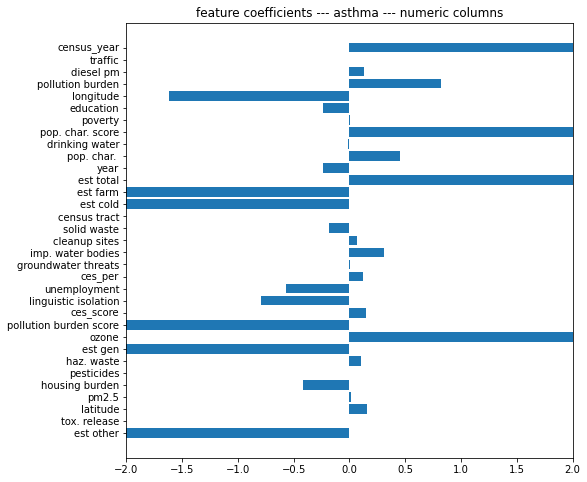

In [218]:
#best on asthma uses a tts of 99:1
a_num_coefs = single_fit(amgd, numeric_cols, 'asthma', 100)
barh_coefs(a_num_coefs, numeric_cols, title = "feature coefficients --- asthma --- numeric columns")

best score:-2.9583150085253305
coefs:
[-5.23894696e+04  1.07898530e-06 -1.40656860e-01  2.09004649e-02
 -6.21594889e-03 -4.99115300e-06  4.94424025e-03 -5.23894465e+04
  9.53658184e-02 -1.67454518e+00  1.57545329e-02 -7.37274248e-03
 -3.43690840e-02  1.37551064e-02 -3.22142947e-04  2.60471788e-03
  2.41505917e-03  3.05497767e-03 -5.38024718e-10 -5.23894777e+04
 -5.23895353e+04  5.23894421e+04 -5.96199016e-02 -6.74924776e-02
  1.43691741e-04  1.13957906e+00 -1.47568422e-02 -2.38110822e-02
 -1.02432710e-01  1.74812272e-01  4.56813525e-03  3.53237106e-05
  1.66682195e-01]


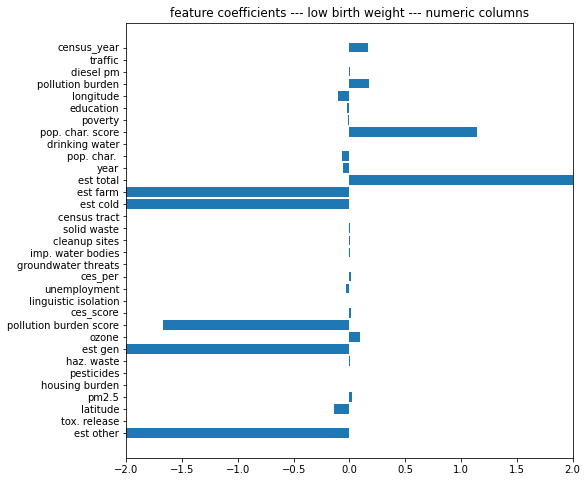

In [220]:
#best fits for others use smaller cross vals.
b_num_coefs = single_fit(amgd, numeric_cols, 'low birth weight', 10)
barh_coefs(b_num_coefs, numeric_cols, title = 'feature coefficients --- low birth weight --- numeric columns')

best score:0.15818166383646987
coefs:
[-5.29113736e+04 -6.44099937e-07  7.70138958e-01  1.27535831e-02
 -8.51448410e-02 -3.87837575e-06  1.74585835e-02 -5.29113542e+04
 -1.79948562e+00 -7.24467541e-01  5.83978655e-03 -6.20534701e-02
 -1.15048077e-01  6.67976249e-02 -2.02779885e-05 -1.24506947e-02
 -5.01052958e-04 -2.48389565e-02  2.80254598e-09 -5.29112734e+04
 -5.29114883e+04  5.29113685e+04  1.39864103e+00 -2.73204782e+00
  7.23354628e-07  2.74897983e+01 -2.75136501e-02 -5.50651389e-03
  8.73855851e-01  3.63187160e-02 -1.23099723e-03 -3.71888587e-05
 -6.51966506e+00]


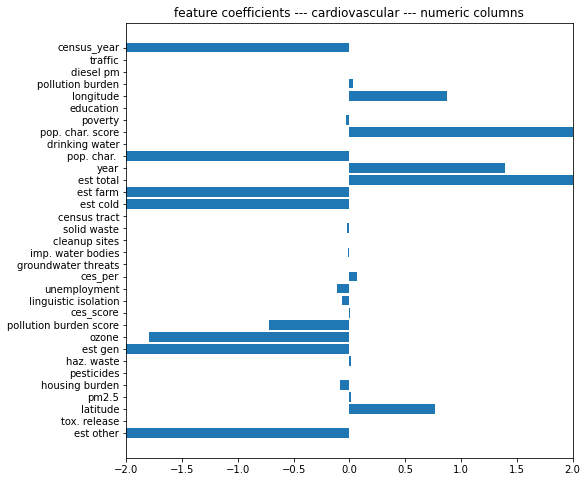

In [221]:
c_num_coefs = single_fit(amgd, numeric_cols, 'cardiovascular disease', 10)
barh_coefs(c_num_coefs, numeric_cols, title = 'feature coefficients --- cardiovascular --- numeric columns')

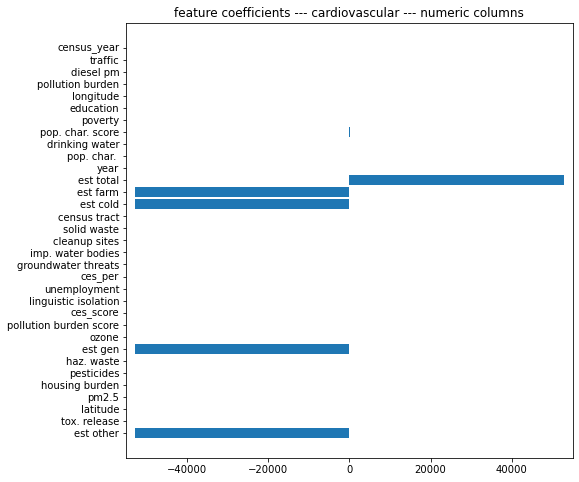

In [226]:
#plot the last one again to see magnitude of largest coefficients.
barh_coefs(c_num_coefs, numeric_cols, xlim = 5.5e4, title = 'feature coefficients --- cardiovascular --- numeric columns')

This is nearly useless, with most of the coefficients in the right range, but a huge reaction +-(10^6) for the warehouses, which end up cancelling each other out. The total is large and positive, the others are all large and negative. This is the form of the results for the following fits, and will be easier to interpret there.

## Linear regressions on time and space features.

The analysis later on primarily ignores these features. There are a few relationships we can draw by looking at them.

In [244]:
time_space_cols = ['year',
                  'latitude',
                  'longitude'
                  ]

train_size_range = np.linspace(0.5,0.99, 10)
cv_range = range(2,12)

In [245]:
%%time
spacetime_results = my_lr_grid_search(amgd, time_space_cols, health_cols, train_sizes = train_size_range, cvs = cv_range)

Wall time: 22.3 s


In [246]:
spacetime_results

[[['parameters', 0.5, 2, 1],
  ['asthma',
   array([0.0813198 , 0.07800861]),
   0.07966420113311842,
   0.05412144771223382],
  ['low birth weight',
   array([0.0813198 , 0.07800861]),
   0.07966420113311842,
   0.02397679050065593],
  ['cardiovascular disease',
   array([0.0813198 , 0.07800861]),
   0.07966420113311842,
   0.16721174776750325]],
 [['parameters', 0.5544444444444444, 2, 1],
  ['asthma',
   array([0.08258266, 0.07782443]),
   0.08020354762853854,
   0.05202759557382175],
  ['low birth weight',
   array([0.08258266, 0.07782443]),
   0.08020354762853854,
   0.025965163692703408],
  ['cardiovascular disease',
   array([0.08258266, 0.07782443]),
   0.08020354762853854,
   0.16717635429616673]],
 [['parameters', 0.6088888888888889, 2, 1],
  ['asthma',
   array([0.08386773, 0.07698929]),
   0.08042851371324827,
   0.052072001031880255],
  ['low birth weight',
   array([0.08386773, 0.07698929]),
   0.08042851371324827,
   0.026433643548552377],
  ['cardiovascular disease',
   

In [247]:
#list for each target,
# params that gave best average cv scores,
# params that gave best test score,
# params that gave minimum difference between the two.

interpret_my_lr_grid_search(spacetime_results, health_cols)

[['asthma',
  ['0.08168', array(['parameters', 0.8266666666666667, 4, 1], dtype=object)],
  ['0.05412', array(['parameters', 0.5, 2, 1], dtype=object)],
  ['0.02537', array(['parameters', 0.5, 11, 1], dtype=object)]],
 ['low birth weight',
  ['0.08168', array(['parameters', 0.8266666666666667, 4, 1], dtype=object)],
  ['0.04155', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['0.03939', array(['parameters', 0.99, 9, 1], dtype=object)]],
 ['cardiovascular disease',
  ['0.08168', array(['parameters', 0.8266666666666667, 4, 1], dtype=object)],
  ['0.18050', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['-0.10021',
   array(['parameters', 0.9355555555555555, 11, 1], dtype=object)]]]

In [297]:
# all of these scores are weak. It's not worth analyzing the coefficients closely.
# if any reflect a real trend, cardiovascular disease increases with time, latitude (going north), and longitude (going east).
# But latitude and longitude are inversely correlated due to the shape of California: these are effectively cancelling
# each other out.

#asthma
single_fit(amgd, time_space_cols, 'asthma')

score:0.054191045852446496
coefs:
[1.07562548 6.45862303 4.83629944]


array([1.07562548, 6.45862303, 4.83629944])

In [298]:
#lbw
single_fit(amgd, time_space_cols, 'low birth weight')

score:0.023412373781223628
coefs:
[-0.0532937  -0.01038596  0.05210202]


array([-0.0532937 , -0.01038596,  0.05210202])

In [300]:
#cvd
cvd_coefs = single_fit(amgd, time_space_cols, 'cardiovascular disease')

score:0.1675741143514312
coefs:
[0.42825805 1.19889717 1.36115313]


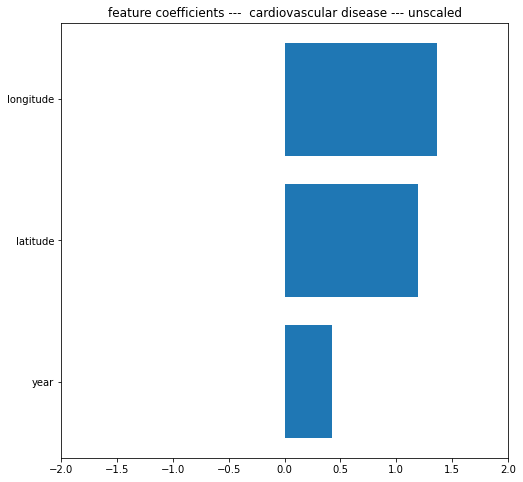

In [309]:
barh_coefs(cvd_coefs, time_space_cols, title = 'feature coefficients ---  cardiovascular disease --- unscaled')

## Linear regression on registered warehouse business counts alone

Exclude the total warehouse count since it is the sum of the others.

In [251]:
#list warehouse count columns to use as features.
warehouse_cols = list(amgd.columns[-4:])
warehouse_cols

['est gen', 'est cold', 'est farm', 'est other']

In [252]:
%%time
#perform linear regressions. 
train_size_range = np.linspace(0.5,0.99, 10)
cv_range = range(2,12)

warehouse_results = my_lr_grid_search(amgd, warehouse_cols, health_cols, train_sizes=train_size_range , cvs=cv_range)

Wall time: 23.8 s


In [253]:
#view best results.
interpret_my_lr_grid_search(warehouse_results, health_cols)

[['asthma',
  ['0.01096', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['0.03795', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['-0.02804', array(['parameters', 0.99, 9, 1], dtype=object)]],
 ['low birth weight',
  ['0.01096', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['0.00396', array(['parameters', 0.8811111111111111, 2, 1], dtype=object)],
  ['0.00571', array(['parameters', 0.8811111111111111, 9, 1], dtype=object)]],
 ['cardiovascular disease',
  ['0.01096', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['0.01780', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['-0.00789', array(['parameters', 0.99, 9, 1], dtype=object)]]]

In [310]:
# Best asthma model fits with two folds
single_fit(amgd, warehouse_cols, 'asthma')

score:0.017315015099094833
coefs:
[ 0.12870905  3.1039741  13.54301779  0.43512254]


array([ 0.12870905,  3.1039741 , 13.54301779,  0.43512254])

In [311]:
# low birth weight
single_fit(amgd, warehouse_cols, 'low birth weight')

score:0.0021640913144613805
coefs:
[0.001611   0.03130058 0.17226919 0.04517863]


array([0.001611  , 0.03130058, 0.17226919, 0.04517863])

In [312]:
# cardiovascular disease
single_fit(amgd, warehouse_cols, 'cardiovascular disease')

score:0.013420443035672802
coefs:
[0.05133218 0.34664342 0.77447558 0.04535199]


array([0.05133218, 0.34664342, 0.77447558, 0.04535199])

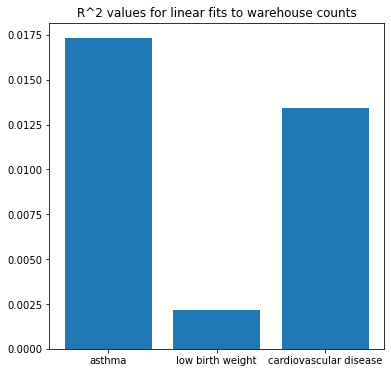

In [319]:
#look at the (poor!) fit scores.
plt.figure(figsize = (6,6))
plt.title("R^2 values for linear fits to warehouse counts")
plt.bar(x=health_cols, height = [0.017315015099094833, 0.0021640913144613805, 0.013420443035672802]);

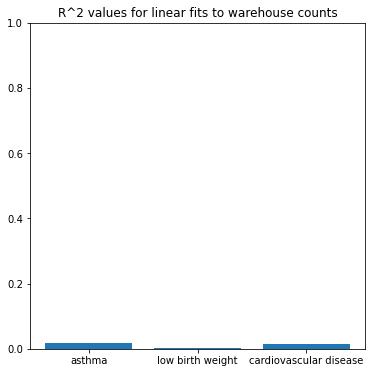

In [320]:
#same but on a scale of 1
plt.figure(figsize = (6,6))
plt.title("R^2 values for linear fits to warehouse counts")
plt.bar(x=health_cols, height = [0.017315015099094833, 0.0021640913144613805, 0.013420443035672802])
plt.ylim(0,1);

## Linear regressions on social features.

In [286]:
# pick out columns representing social impacts.
# do not include CAES specific scores, which are partly derived from these.
social_cols = [
    'total population',
    'traffic',
    'education',
    'linguistic isolation',
    'poverty',
    'unemployment',
    'housing burden'
]

In [287]:
%%time
#perform linear regression with these columns as features.

train_size_range = np.linspace(0.5,0.99, 10)
cv_range = range(2,12)

social_results = my_lr_grid_search(amgd, social_cols, health_cols, train_sizes=train_size_range , cvs=cv_range)

Wall time: 29.6 s


In [288]:
#view best results.
interpret_my_lr_grid_search(social_results, health_cols)

[['asthma',
  ['0.17229', array(['parameters', 0.5544444444444444, 4, 1], dtype=object)],
  ['0.30700', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['-0.13924', array(['parameters', 0.99, 2, 1], dtype=object)]],
 ['low birth weight',
  ['0.17229', array(['parameters', 0.5544444444444444, 4, 1], dtype=object)],
  ['0.13699', array(['parameters', 0.7177777777777777, 2, 1], dtype=object)],
  ['0.02988', array(['parameters', 0.7177777777777777, 2, 1], dtype=object)]],
 ['cardiovascular disease',
  ['0.17229', array(['parameters', 0.5544444444444444, 4, 1], dtype=object)],
  ['0.11048', array(['parameters', 0.8811111111111111, 2, 1], dtype=object)],
  ['0.05692', array(['parameters', 0.8811111111111111, 2, 1], dtype=object)]]]

In [324]:
#asthma
a_coefs = single_fit(amgd, social_cols, 'asthma')

score:0.26303315227192514
coefs:
[-8.21816240e-05 -7.31466637e-04  3.86763511e-01 -7.75487433e-01
  6.03119565e-01  2.60286191e-01  2.69008534e-01]


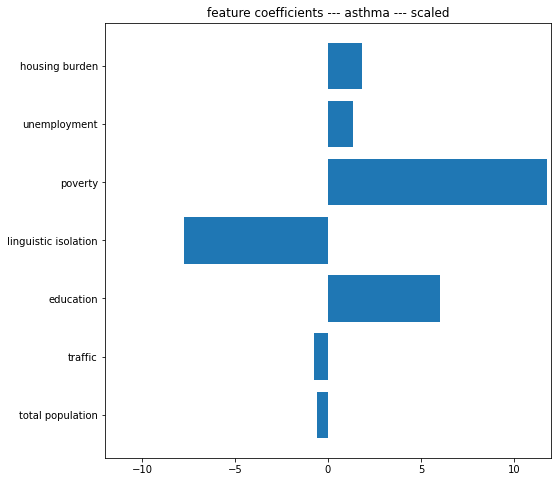

In [335]:
scaled_a_coefs = get_scaled_coefs(amgd, social_cols, a_coefs)
barh_coefs(scaled_a_coefs, social_cols, xlim=12, title = 'feature coefficients --- asthma --- scaled')

In [327]:
# low birth weight
b_coefs = single_fit(amgd, social_cols, 'low birth weight')

score:0.133746904321276
coefs:
[ 3.93667561e-05  4.85884510e-05  7.20557815e-03 -5.85265249e-03
  5.96124139e-03  1.82984946e-02  3.22819066e-02]


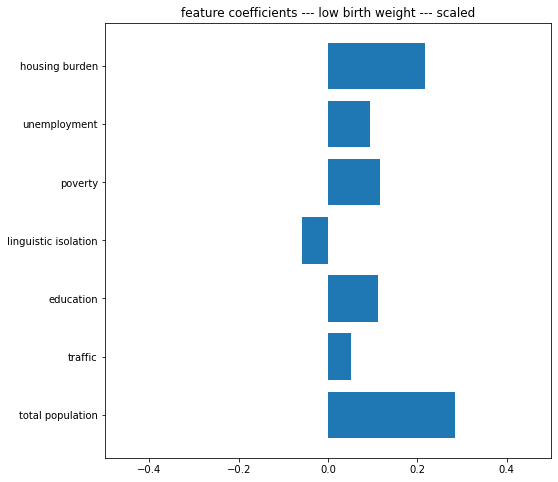

In [340]:
scaled_b_coefs = get_scaled_coefs(amgd, social_cols, b_coefs)
barh_coefs(scaled_b_coefs, social_cols, xlim = 0.5, title = 'feature coefficients --- low birth weight --- scaled')

In [339]:
c_coefs = single_fit(amgd, social_cols, 'cardiovascular disease')

score:0.11002613052568344
coefs:
[-5.50076599e-06 -5.24843161e-05  8.24879626e-02 -1.03093467e-01
  3.84086500e-02 -1.30230685e-01  3.55923445e-02]


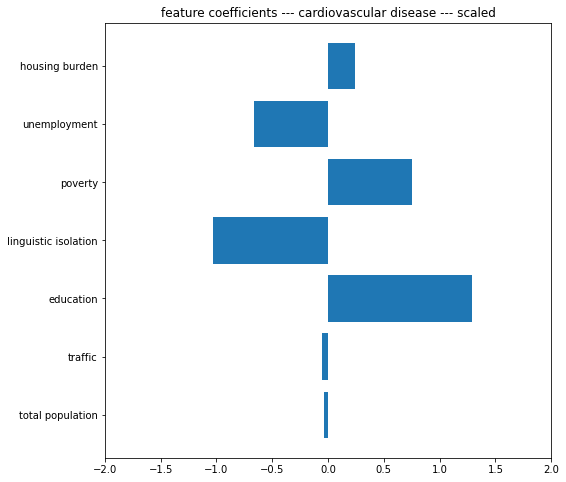

In [341]:
scaled_c_coefs = get_scaled_coefs(amgd, social_cols, c_coefs)
barh_coefs(scaled_c_coefs, social_cols, title = 'feature coefficients --- cardiovascular disease --- scaled')

## Linear regressions on CAES scores.

If these fits are good, we may consider the scores as well-designed.

In [154]:
#define the CAES-specific scores.
score_cols = [
    'pollution burden score',
    'pop. char. ',
    'ces_score',
    'housing burden'
]

In [155]:
%%time
#perform linear regression with these columns as features.

train_size_range = np.linspace(0.5,0.99, 10)
cv_range = range(2,12)

CAES_score_results = my_lr_grid_search(amgd, score_cols, health_cols, train_sizes=train_size_range , cvs=cv_range)

Wall time: 26.1 s


In [161]:
#view best results.
interpret_my_lr_grid_search(CAES_score_results, health_cols)

[['asthma',
  ['0.31981', array(['parameters', 0.6633333333333333, 4, 1], dtype=object)],
  ['0.49012', array(['parameters', 0.99, 2, 1], dtype=object)],
  ['-0.17082', array(['parameters', 0.99, 9, 1], dtype=object)]],
 ['low birth weight',
  ['0.31981', array(['parameters', 0.6633333333333333, 4, 1], dtype=object)],
  ['0.26046', array(['parameters', 0.9355555555555555, 2, 1], dtype=object)],
  ['0.05775', array(['parameters', 0.9355555555555555, 11, 1], dtype=object)]],
 ['cardiovascular disease',
  ['0.31981', array(['parameters', 0.6633333333333333, 4, 1], dtype=object)],
  ['0.23645', array(['parameters', 0.5, 2, 1], dtype=object)],
  ['0.08037', array(['parameters', 0.5, 11, 1], dtype=object)]]]

In [186]:
# perform another fit for each of the best. Pick a cv that minimizes the difference between scores.
single_fit(amgd, score_cols, 'asthma', 9)

best score:0.34113817641568134
coefs:
[-0.3040038   1.04964966  0.13762272 -0.38603496]


array([-0.3040038 ,  1.04964966,  0.13762272, -0.38603496])

In [187]:
score_cols

['pollution burden', 'pop. char. ', 'ces_score', 'housing burden']

## Linear regressions on select impact columns